# Analyse Magnetic Margins Data

In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns
from io import StringIO
import requests
from scipy.stats import entropy

## Get the Data

In [2]:
# URLs to CSV files
url_annotations = "https://share.ninox.com/q18j4vz02xh9zey7h8kd1uvwmok6im18bk2e" # "tsne_annotations.csv"
# not like "editorial" and not like "owner" and not like "librar" and not like "shelfmark"
url_sections = "https://share.ninox.com/8wcyso7x62f18lyk9mniaxcdhnlv0hhh8k7z" # "tsne_sub-structures.csv"
url_copies = "https://share.ninox.com/fg5zcsnh4owga8n9kjosf2aiz9p9cus9bdeq" # "tsne_copies.csv"

def load_csv_from_url(url):
    response = requests.get(url)
    data = response.text
    return pd.read_csv(StringIO(data))

# Load
annotations = load_csv_from_url(url_annotations)
sections = load_csv_from_url(url_sections)
copies = load_csv_from_url(url_copies)
# annotations = annotations.drop_duplicates()
annotations = annotations.dropna(subset=['copy.Id', 'printed page.Id'])


## Basisc Stats

In [3]:
total_annotations = len(annotations)

# 2. number of all annotated pages
total_annotated_pages = annotations['printed page.Id'].nunique()

# 3. number of all copies
total_copies = annotations['copy.Id'].nunique()

# Output of the results
print(f"Number of all annotations: {total_annotations}")
print(f"Number of all annotated pages: {total_annotated_pages}")
print(f"Number of all annotated copies: {total_copies} / {len(copies)}")

Number of all annotations: 6715
Number of all annotated pages: 4558
Number of all annotated copies: 272 / 375


In [4]:
# Number of pages per copy
pages_per_copy = annotations.groupby('copy.Id')['printed page.Id'].nunique().reset_index()
pages_per_copy.rename(columns={'printed page.Id': 'CNT_PAGES'}, inplace=True)

print(pages_per_copy.head())

   copy.Id  CNT_PAGES
0     1013          3
1     1019          1
2     1020         56
3     1021          2
4     1022          1


In [5]:
# Group by 'copy.Id' and count the unique 'printed page.Id'
pages_counts = annotations.groupby('copy.Id')['printed page.Id'].nunique().reset_index()
pages_counts.rename(columns={'printed page.Id': 'CNT_PAGES'}, inplace=True)

print("\nNumber of annotated pages per copy (only with annotations):")
print(pages_counts.head())
# Merge the DataFrames
pages_per_copy = copies.merge(pages_counts, how='left', left_on='Id', right_on='copy.Id')
pages_per_copy.rename(columns={'CNT_PAGES': 'CNT_PAGES'}, inplace=True)

# Fill missing values (NaN) with 0, as these copies have no annotations
pages_per_copy['CNT_PAGES'] = pages_per_copy['CNT_PAGES'].fillna(0).astype(int)





Number of annotated pages per copy (only with annotations):
   copy.Id  CNT_PAGES
0     1013          3
1     1019          1
2     1020         56
3     1021          2
4     1022          1


In [6]:
average = pages_per_copy['CNT_PAGES'].mean()
median = pages_per_copy['CNT_PAGES'].median()

print(f"Average number of pages per copy: {average}")
print(f"Median number of pages per copy: {median}")

Average number of pages per copy: 12.112
Median number of pages per copy: 2.0


In [7]:
def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumulative = np.cumsum(sorted_x)
    relative_cumulative = cumulative / cumulative[-1]
    lorenz_curve = relative_cumulative
    gini = 1 - 2 * np.trapz(lorenz_curve, dx=1/n)
    return gini

gini = gini_coefficient(pages_per_copy['CNT_PAGES'].values)
print(f"Gini coefficient: {gini}")

Gini coefficient: 0.8251765741963892


In [8]:
value_counts = pages_per_copy['CNT_PAGES'].value_counts(normalize=True)
my_entropy = entropy(value_counts, base=2)

print(f"Entropy of the distribution: {my_entropy}")

Entropy of the distribution: 3.871708849038133


In [9]:
standard_deviation = pages_per_copy['CNT_PAGES'].std()
variance = pages_per_copy['CNT_PAGES'].var()
skewness = pages_per_copy['CNT_PAGES'].skew()
kurtosis = pages_per_copy['CNT_PAGES'].kurtosis()

# Ausgabe der Ergebnisse
print(f"standard deviation: {standard_deviation}")
print(f"varianz: {variance}")
print(f"skewness: {skewness}")
print(f"kurtosis: {kurtosis}")

standard deviation: 32.24485599235813
varianz: 1039.7307379679144
skewness: 4.6115338201972795
kurtosis: 24.727317465165456


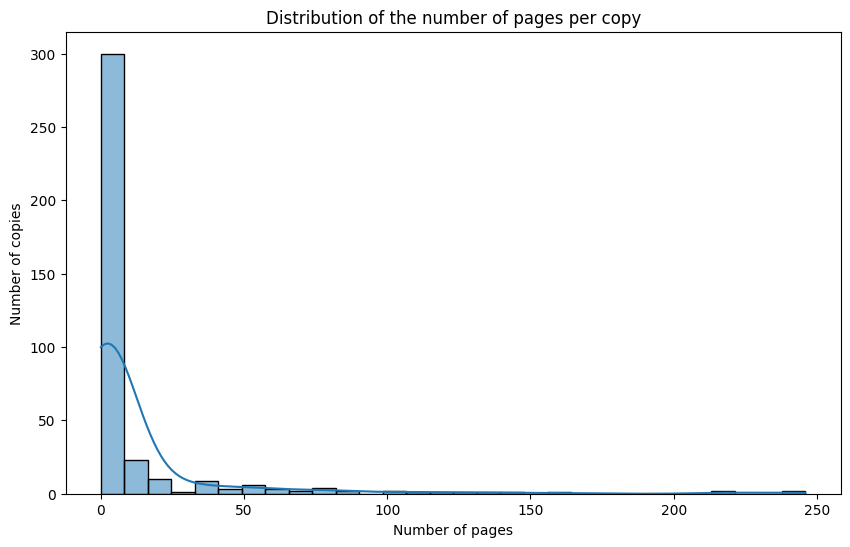

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(pages_per_copy['CNT_PAGES'], bins=30, kde=True)
plt.title('Distribution of the number of pages per copy')
plt.xlabel('Number of pages')
plt.ylabel('Number of copies')
plt.show()


To cover 50% of the annotations, you need the top 4.53% of the copies.

Relevant copies:
    copy.Id  CNT_PAGES  cum_total  cum_percentages
0    1357.0        246        246         5.416116
1    1369.0        239        485        10.678115
2    1355.0        221        706        15.543813
3    1483.0        217        923        20.321444
4    1458.0        161       1084        23.866138
5    1443.0        145       1229        27.058565
6    1500.0        136       1365        30.052840
7    1332.0        124       1489        32.782915
8    1362.0        120       1609        35.424923
9    1555.0        107       1716        37.780713
10   1026.0        103       1819        40.048437
11   1315.0        101       1920        42.272127
12   1364.0         85       2005        44.143549
13   1819.0         82       2087        45.948921
14   1551.0         81       2168        47.732277
15   1527.0         80       2248        49.493615
16   1627.0         78       2326        51.

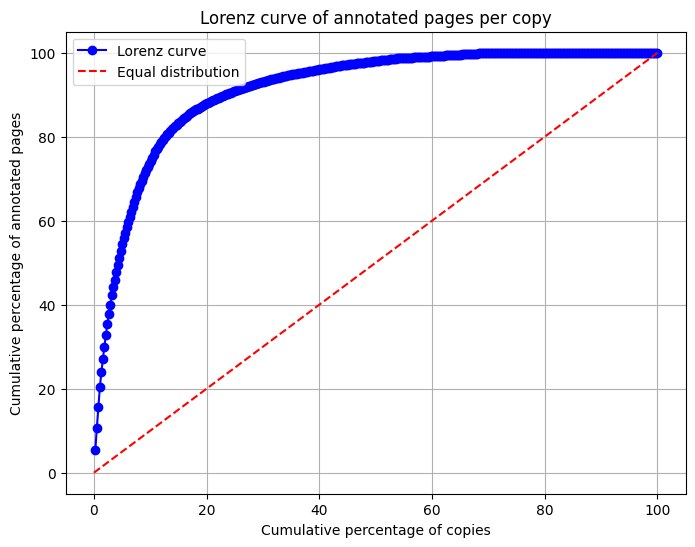

In [11]:
total_annotations = pages_per_copy['CNT_PAGES'].sum()

# Sort the copies by number of annotations in descending order
pages_per_copy_sorted = pages_per_copy.sort_values(by='CNT_PAGES', ascending=False).reset_index(drop=True)

# Calculate cumulative total
pages_per_copy_sorted['cum_total'] = pages_per_copy_sorted['CNT_PAGES'].cumsum()

# Calculate cumulative percentages
pages_per_copy_sorted['cum_percentages'] = (pages_per_copy_sorted['cum_total'] / total_annotations) * 100

# Cumulative percentages of copies
pages_per_copy_sorted['cum_percentage_copy'] = (np.arange(1, len(pages_per_copy_sorted) + 1) / len(pages_per_copy_sorted)) * 100

# Set target percentage
target_percentage = 50  # e.g. 90%

top_copies = pages_per_copy_sorted[pages_per_copy_sorted['cum_percentages'] <= target_percentage].copy()

# If the exact target percentage is not reached, include the next entry
if not top_copies.empty and top_copies['cum_percentages'].iloc[-1] < target_percentage and len(top_copies) < len(pages_per_copy_sorted):
    next_row = pages_per_copy_sorted.iloc[[len(top_copies)]]
    top_copies = pd.concat([top_copies, next_row], ignore_index=True)


# Calculation of the percentage of copies
percent_copies = (len(top_copies) / len(pages_per_copy_sorted)) * 100

print(f"To cover {target_percentage}% of the annotations, you need the top {percent_copies:.2f}% of the copies.")
print("\nRelevant copies:")
print(top_copies[['copy.Id', 'CNT_PAGES', 'cum_total', 'cum_percentages']])

plt.figure(figsize=(8,6))
plt.plot(pages_per_copy_sorted['cum_percentage_copy'], pages_per_copy_sorted['cum_percentages'], marker='o', linestyle='-', color='b', label='Lorenz curve')
plt.plot([0, 100], [0, 100], linestyle='--', color='r', label='Equal distribution')
plt.xlabel('Cumulative percentage of copies')
plt.ylabel('Cumulative percentage of annotated pages')
plt.title('Lorenz curve of annotated pages per copy')
plt.legend()
plt.grid(True)
plt.show()

              count       mean        std  min  25%  50%  75%    max
Edition                                                             
Gilbert 1600  203.0  13.177340  31.869599  0.0  1.0  3.0  8.0  246.0
Gilbert 1628   77.0  15.194805  38.389294  0.0  0.0  2.0  5.0  221.0
Gilbert 1629    6.0   0.833333   1.329160  0.0  0.0  0.0  1.5    3.0
Gilbert 1633   89.0   7.775281  27.855452  0.0  0.0  1.0  5.0  239.0


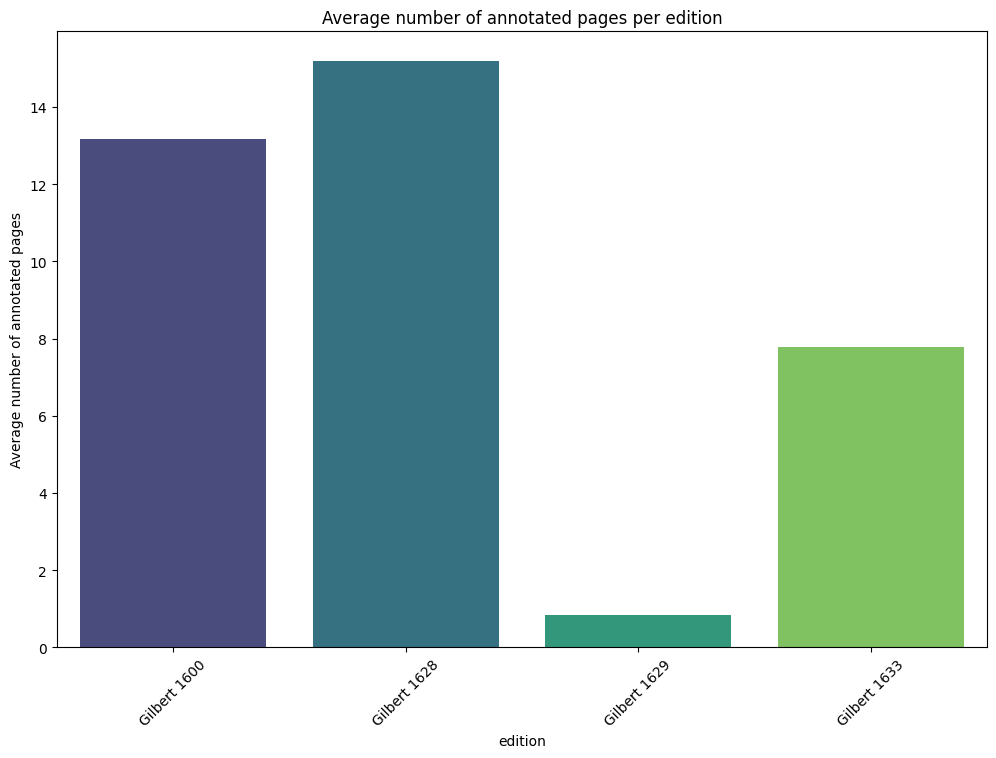

In [12]:
desc_stats = pages_per_copy.groupby('Edition')['CNT_PAGES'].describe()
print(desc_stats)

avg_annotations = pages_per_copy.groupby('Edition')['CNT_PAGES'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Edition', y='CNT_PAGES', data=avg_annotations, palette='viridis')
plt.title('Average number of annotated pages per edition')
plt.xlabel('edition')
plt.ylabel('Average number of annotated pages')
plt.xticks(rotation=45)
plt.show()

In [13]:
from scipy.stats import f_oneway

groups = [group['CNT_PAGES'].values for name, group in pages_per_copy.groupby('Edition')]
stat, p = f_oneway(*groups)
print(f"ANOVA: F-Statistik = {stat:.4f}, p-Wert = {p:.4f}")

if p < 0.05:
    print("There are significant differences between the editions.")
else:
    print("No significant differences found between the editions.")


ANOVA: F-Statistik = 1.0906, p-Wert = 0.3530
No significant differences found between the editions.


In [14]:
if None:
    ! pip install statsmodels
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    model = ols('CNT_PAGES ~ C(Edition)', data=pages_per_copy).fit()

    # Carrying out the Tukey HSD test
    tukey = pairwise_tukeyhsd(endog=pages_per_copy['CNT_PAGES'],
                            groups=pages_per_copy['Edition'],
                            alpha=0.05)
    print("\nTukey HSD test results:")
    print(tukey)

## Transformations

In [15]:
topic_row="parent tags" # or: "topics Englisch", "topics Latin", "name" (=chapter), "parent" (=book), parent tags
ignore_list = ['lapis','does','let','like']  # List of topics to be ignored

In [16]:
# Split by comma if possible
has_commas = any(',' in str(topic) for topic in sections[topic_row])

all_topics = []
if has_commas:
    for topics in sections[topic_row]:
        if isinstance(topics, str):
            cleaned_topics = [topic.strip() for topic in topics.split(',') if topic.strip() not in ignore_list]
            all_topics.extend(cleaned_topics)
else:
    for topic in sections[topic_row]:
        if isinstance(topic, str) and topic.strip() not in ignore_list:
            all_topics.append(topic.strip())

# count the most frequently occurring topics
topics_counts = Counter(all_topics)
print("Number of all unique topics:", len(topics_counts))

Number of all unique topics: 20


In [17]:
def normalize_data(sections, copies, annotations, ignore_list, normalization_method):

    has_commas = any(',' in str(topic) for topic in sections[topic_row])

    topics_counts = Counter()

    all_topics = sections[topic_row].str.split(',').explode().str.strip().unique()
    filtered_topics = [topic for topic in all_topics if topic not in ignore_list]

    # Create the DataFrame before the loop
    vector_df_norm = pd.DataFrame(columns=['Id'] + filtered_topics)
    vector_df_norm['Id'] = copies['Id']
    vector_df_norm = vector_df_norm.set_index('Id').fillna(0)

    for index, row in copies.iterrows():
        exemplar_id = row['Id']
        relevant_annotations = annotations[annotations['copy.Id'] == exemplar_id]
        total_annotations = relevant_annotations['weighted'].sum()

        for _, annotation in relevant_annotations.iterrows():
            anzahl = annotation['weighted']
            sec_ids_string = annotation['concat(substructures.Id)']
            if isinstance(sec_ids_string, str):
                sec_ids = sec_ids_string.split(',') if ',' in sec_ids_string else [sec_ids_string]
                for kap_id in sec_ids:
                    matching_rows = sections[sections['Id'] == int(kap_id)]
                    if not matching_rows.empty:
                        topics_in_sections = matching_rows[topic_row].iloc[0]
                        if isinstance(topics_in_sections, str):        
                            if has_commas:
                                cleaned_topics = [topic.strip() for topic in topics_in_sections.split(',') if topic.strip() not in ignore_list]
                            else:
                                cleaned_topics = [topics_in_sections.strip()] if topics_in_sections.strip() not in ignore_list else []

                            # Update the DataFrame for each cleaned topic
                            for topic in cleaned_topics:
                                if topic in vector_df_norm.columns:
                                    if normalization_method == 'proportional':
                                        normalized_value = anzahl / total_annotations if total_annotations > 0 else 0
                                    elif normalization_method == 'unweighted absolute values':
                                        normalized_value = anzahl
                                    elif normalization_method ==  'frequency': #'weighted absolute values'
                                        normalized_value = anzahl  # Number is multiplied below
                                    elif normalization_method == 'percentage':
                                        normalized_value = anzahl / total_annotations if total_annotations > 0 else 0
                                    vector_df_norm.at[exemplar_id, topic] += normalized_value
                                    topics_counts[topic] += normalized_value

    # Calculate the number of copies that commented on each topic after vector_df_norm was updated
    topics_part_counts = (vector_df_norm > 0).sum()

    # Update the DataFrame with weighted values
    if normalization_method == 'frequency':
        for topic in topics_part_counts.index:
            vector_df_norm[topic] *= topics_part_counts[topic]

    # Calculate percentage per dimension
    elif normalization_method == 'percentage':
        for exemplar_id in vector_df_norm.index:
            total_value = vector_df_norm.loc[exemplar_id].sum()
            if total_value > 0:
                vector_df_norm.loc[exemplar_id] = vector_df_norm.loc[exemplar_id] / total_value

    return vector_df_norm

Define method and call

In [18]:
normalization_method = 'percentage'
vector_df = normalize_data(sections, copies, annotations, ignore_list, normalization_method)

In [19]:
vector_df.head(10)

,polarity,mineralogy,specimen,natural history,medicine,doxography,causal explanation,magnetic force,sphere of activity,attraction/repulsion,theoretical,compass,instrument,direction,practice,declination,navigation,inclination,astronomy/astrology/cosmology,Copernicanism
Id,,,,,,,,,,,,,,,,,,,,
1013,0.100000,0.066667,0.066667,0.066667,0.066667,0.066667,0.100000,0.033333,0.033333,0.033333,0.033333,0.066667,0.066667,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000
1019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1020,0.151737,0.138940,0.138940,0.138940,0.138940,0.138940,0.029250,0.029250,0.012797,0.012797,0.029250,0.001828,0.001828,0.000000,0.001828,0.000000,0.000000,0.001828,0.016453,0.016453
1021,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1024,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.181818,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.000000
1025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1026,0.120240,0.073146,0.073146,0.073146,0.073146,0.073146,0.087174,0.077154,0.043086,0.043086,0.077154,0.027054,0.027054,0.004008,0.027054,0.010020,0.010020,0.013026,0.034068,0.034068
1027,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
len(topics_counts)#
# print(topics_counts)

20

The final filter is used to retain only those copies that have a sufficiently large number of topic references. This reduces the amount of data to those units that are significantly related to the topics under consideration and helps to focus the analysis on the most relevant copies. The filter ensures that only data sets with a substantial topic total are considered further, which helps to exclude noise and less relevant data points.

In [21]:
# Calculate the mean value of the sum of each row
mean_sum = vector_df.iloc[:, 1:].sum(axis=1).mean()
print("mean_sum: ", mean_sum)

# Set a threshold based on 50% of the average
threshold = 0.5 * mean_sum
print("threshold:", threshold)

# Filter the DataFrame based on the threshold value
filtered_df = vector_df[vector_df.iloc[:, 1:].sum(axis=1) >= threshold]
print("copies:", len(filtered_df))

# When all items have been filtered, reduce the threshold value
if len(filtered_df) == 0:
    threshold = 0.1 * mean_sum  # Reduce the threshold value to 10% of the mean value
    filtered_df = vector_df[vector_df.iloc[:, 1:].sum(axis=1) >= threshold]
    print("New threshold value:", threshold)
    print("New number of copies:", len(vector_df))


mean_sum:  0.38581665683906247
threshold: 0.19290832841953123
copies: 165


In [22]:
vector_df = filtered_df

In [23]:
len(vector_df)

165

Check after normalisation for percentage (sum per line = 1)

In [24]:
if normalization_method == 'percentage':
    print("Checking the line totals:")
    for exemplar_id in vector_df.index:
        row_sum = vector_df.loc[exemplar_id].sum()
        if not np.isclose(row_sum, 1):
            print(f"Warning: The sum of the line {exemplar_id} does not equal 1 but {row_sum:.2f}")


Checking the line totals:


In [25]:
vector_df.head(10)

,polarity,mineralogy,specimen,natural history,medicine,doxography,causal explanation,magnetic force,sphere of activity,attraction/repulsion,theoretical,compass,instrument,direction,practice,declination,navigation,inclination,astronomy/astrology/cosmology,Copernicanism
Id,,,,,,,,,,,,,,,,,,,,
1013,0.100000,0.066667,0.066667,0.066667,0.066667,0.066667,0.100000,0.033333,0.033333,0.033333,0.033333,0.066667,0.066667,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000
1020,0.151737,0.138940,0.138940,0.138940,0.138940,0.138940,0.029250,0.029250,0.012797,0.012797,0.029250,0.001828,0.001828,0.000000,0.001828,0.000000,0.000000,0.001828,0.016453,0.016453
1021,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1024,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.181818,0.090909,0.181818,0.090909,0.090909,0.000000,0.000000,0.000000
1026,0.120240,0.073146,0.073146,0.073146,0.073146,0.073146,0.087174,0.077154,0.043086,0.043086,0.077154,0.027054,0.027054,0.004008,0.027054,0.010020,0.010020,0.013026,0.034068,0.034068
1027,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1050,0.134969,0.064417,0.064417,0.064417,0.064417,0.064417,0.095092,0.064417,0.061350,0.061350,0.064417,0.039877,0.039877,0.009202,0.039877,0.030675,0.030675,0.000000,0.003067,0.003067
1051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000
1054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.134146,0.048780,0.000000,0.000000,0.048780,0.146341,0.146341,0.000000,0.146341,0.085366,0.085366,0.060976,0.048780,0.048780


In [26]:
Top_X = 10
# Checking the extracted features
# print("All features:", list(vector_df.columns))

# Calculate the sum of the normalized values for each topic in the DataFrame
topics_normalized_frequencies = vector_df.sum()  # Remove 'Id' if it is present in the columns

# Sort the features based on their normalized frequencies and select the top X
top_topics_frequencies = topics_normalized_frequencies.sort_values(ascending=False).head(Top_X)

# Extract the top topics and their normalized frequencies
top_topics = top_topics_frequencies.index.tolist()
top_frequencies = top_topics_frequencies.values.tolist()

# Extract the 20 most common features and their frequencies
# top_topics = [item[0] for item in topics_counts.most_common(150)]
# top_frequencies = [item[1] for item in topics_counts.most_common(150)]

print("Top features:", top_topics)
print("Top frequencies:", top_frequencies)

# DataFrame of the top features with their frequencies
top_topics_df = pd.DataFrame({
    'topic': top_topics,
    'frequency': top_frequencies
})

Top features: ['polarity', 'causal explanation', 'magnetic force', 'theoretical', 'medicine', 'doxography', 'natural history', 'specimen', 'mineralogy', 'sphere of activity']
Top frequencies: [20.318753685351574, 14.223366885628263, 11.739522873751563, 11.739522873751563, 10.737465511684654, 10.737465511684654, 10.737465511684654, 10.737465511684654, 10.737465511684654, 7.465690356336156]


# Frequencies

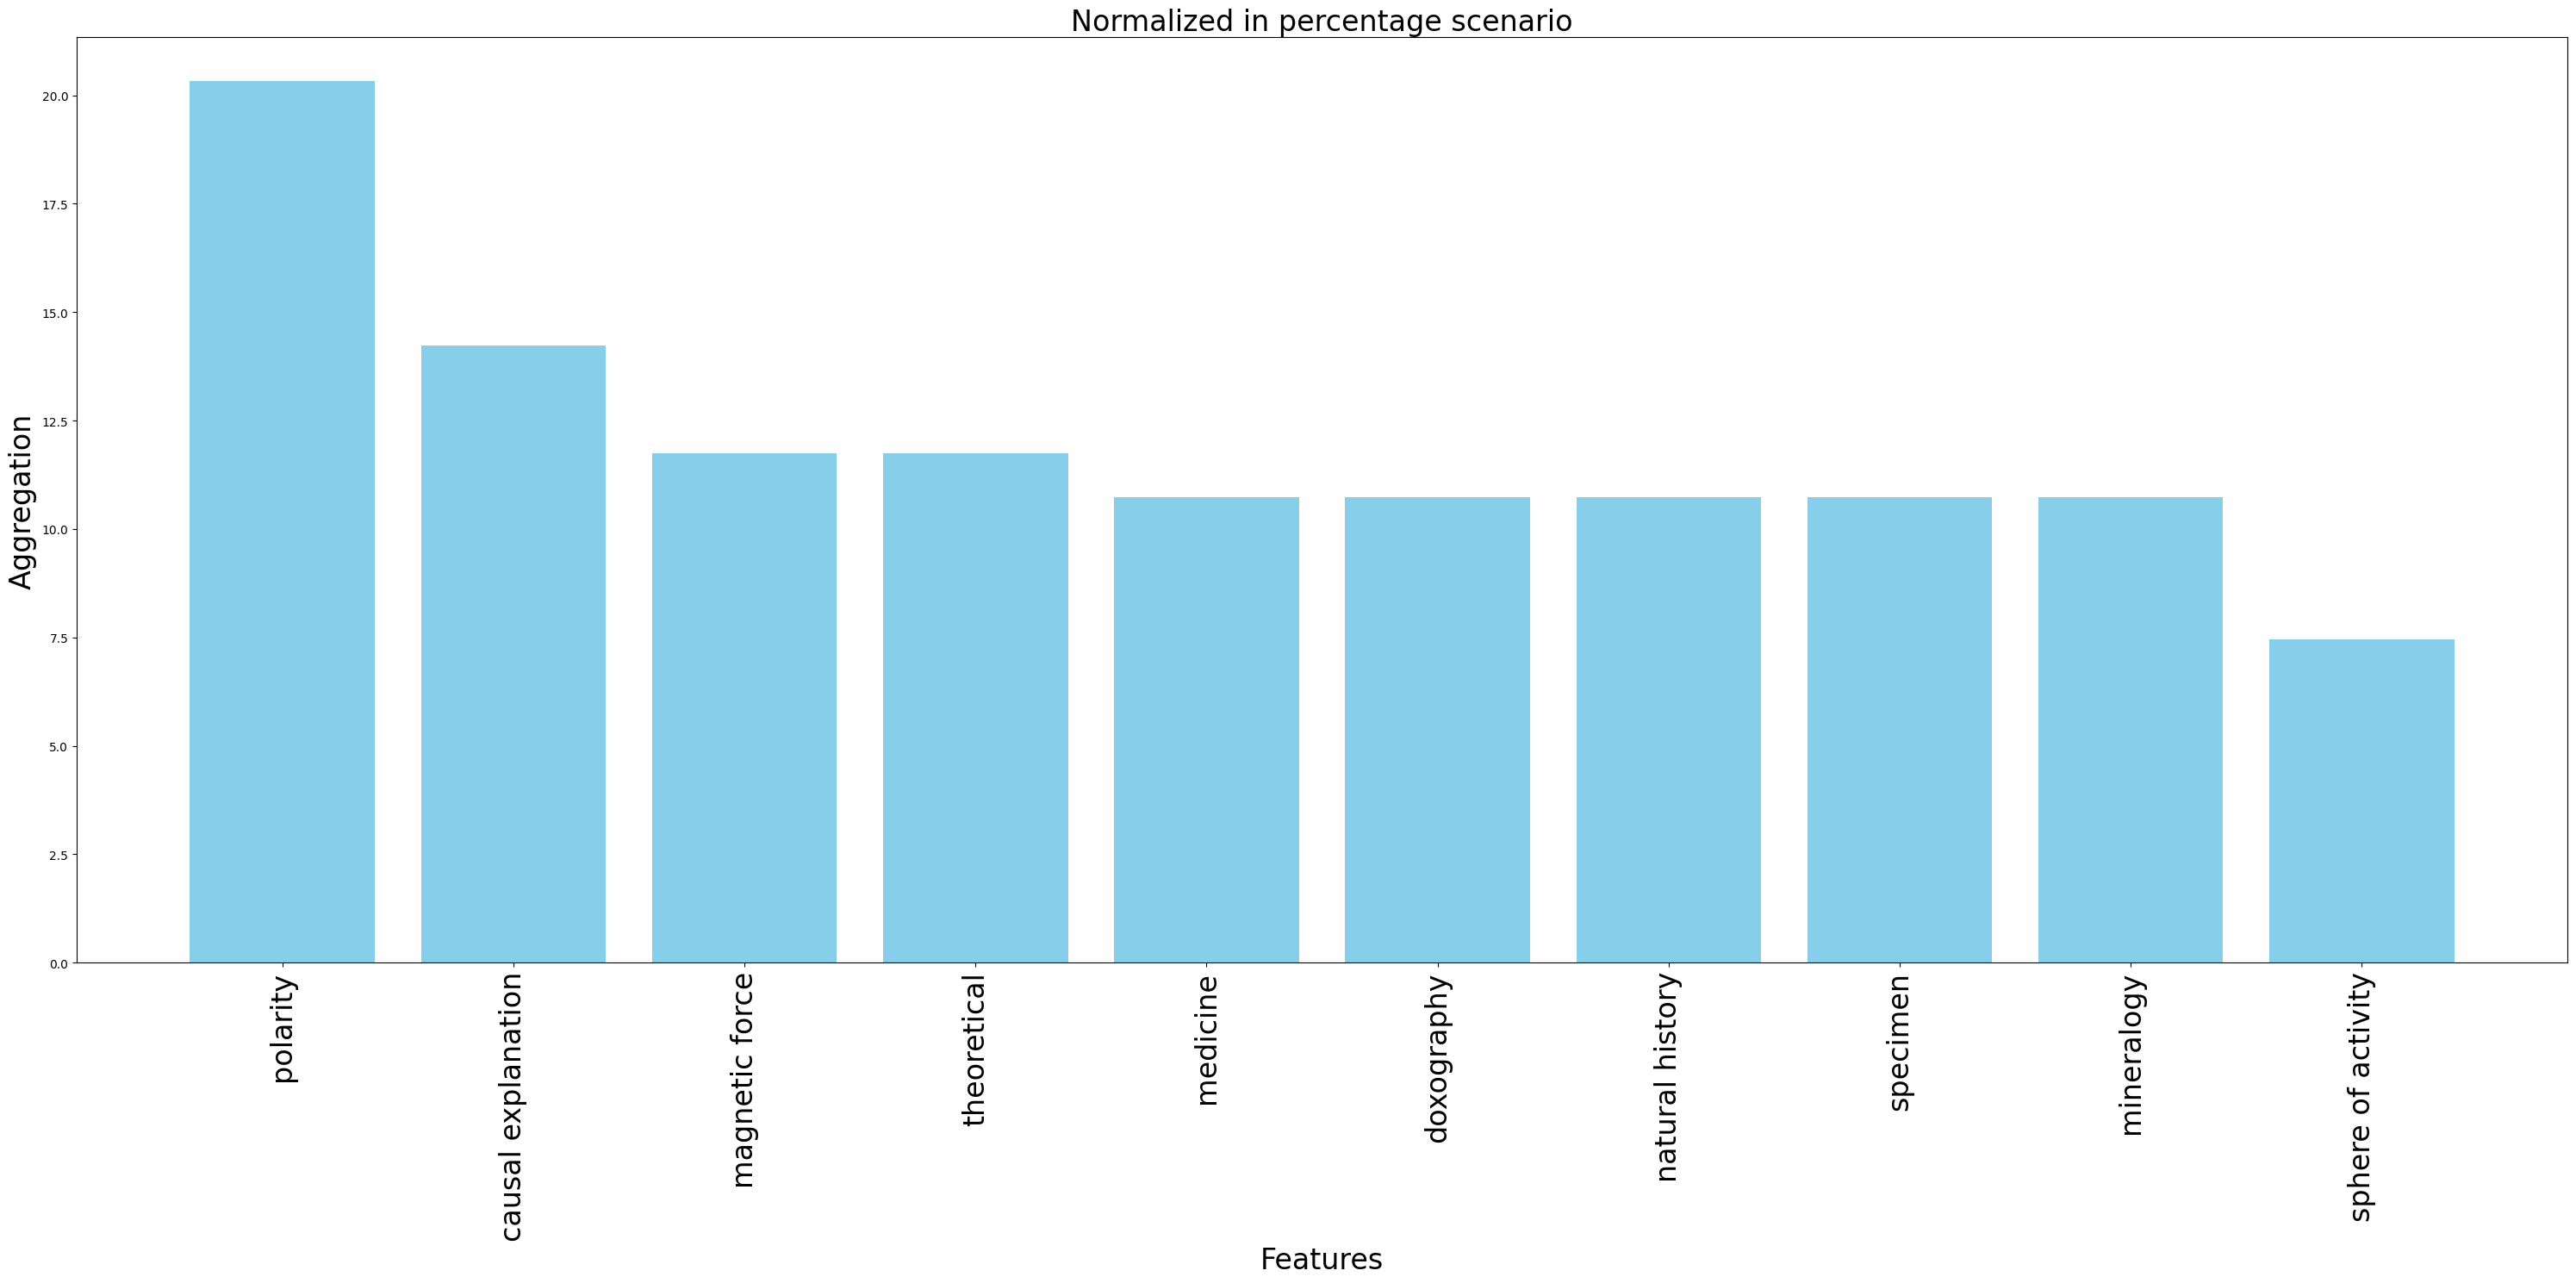

In [27]:
# 'order_c'
sections_topics = sections.explode(topic_row)
sections_topics[topic_row] = sections_topics[topic_row].str.strip()
top_topics_df = top_topics_df.merge(sections_topics[[topic_row, 'order_c']], left_on='topic', right_on=topic_row, how='left').drop(columns=[topic_row])

# Sort the features by 'order_c'
top_topics_df = top_topics_df.sort_values(by='order_c')

plt.figure(figsize=(30, 15))
plt.bar(top_topics_df['topic'], top_topics_df['frequency'], color='skyblue')
plt.xlabel('Features', fontsize=24)
plt.ylabel('Aggregation', fontsize=24)
plt.title(f'Normalized in {normalization_method} scenario', fontsize=24)
plt.xticks(rotation=90, fontsize=24)
plt.tight_layout()
plt.show()

# Co-occurence

In [28]:
top_topics = topics_counts #top_topics_df['topic'].tolist()
co_occurrence_matrix = pd.DataFrame(index=top_topics, columns=top_topics).fillna(0)
for index, row in vector_df.iterrows():
    for topic1 in top_topics:
        for topic2 in top_topics:
            if row[topic1] > 0 and row[topic2] > 0:
                co_occurrence_matrix.at[topic1, topic2] += 1

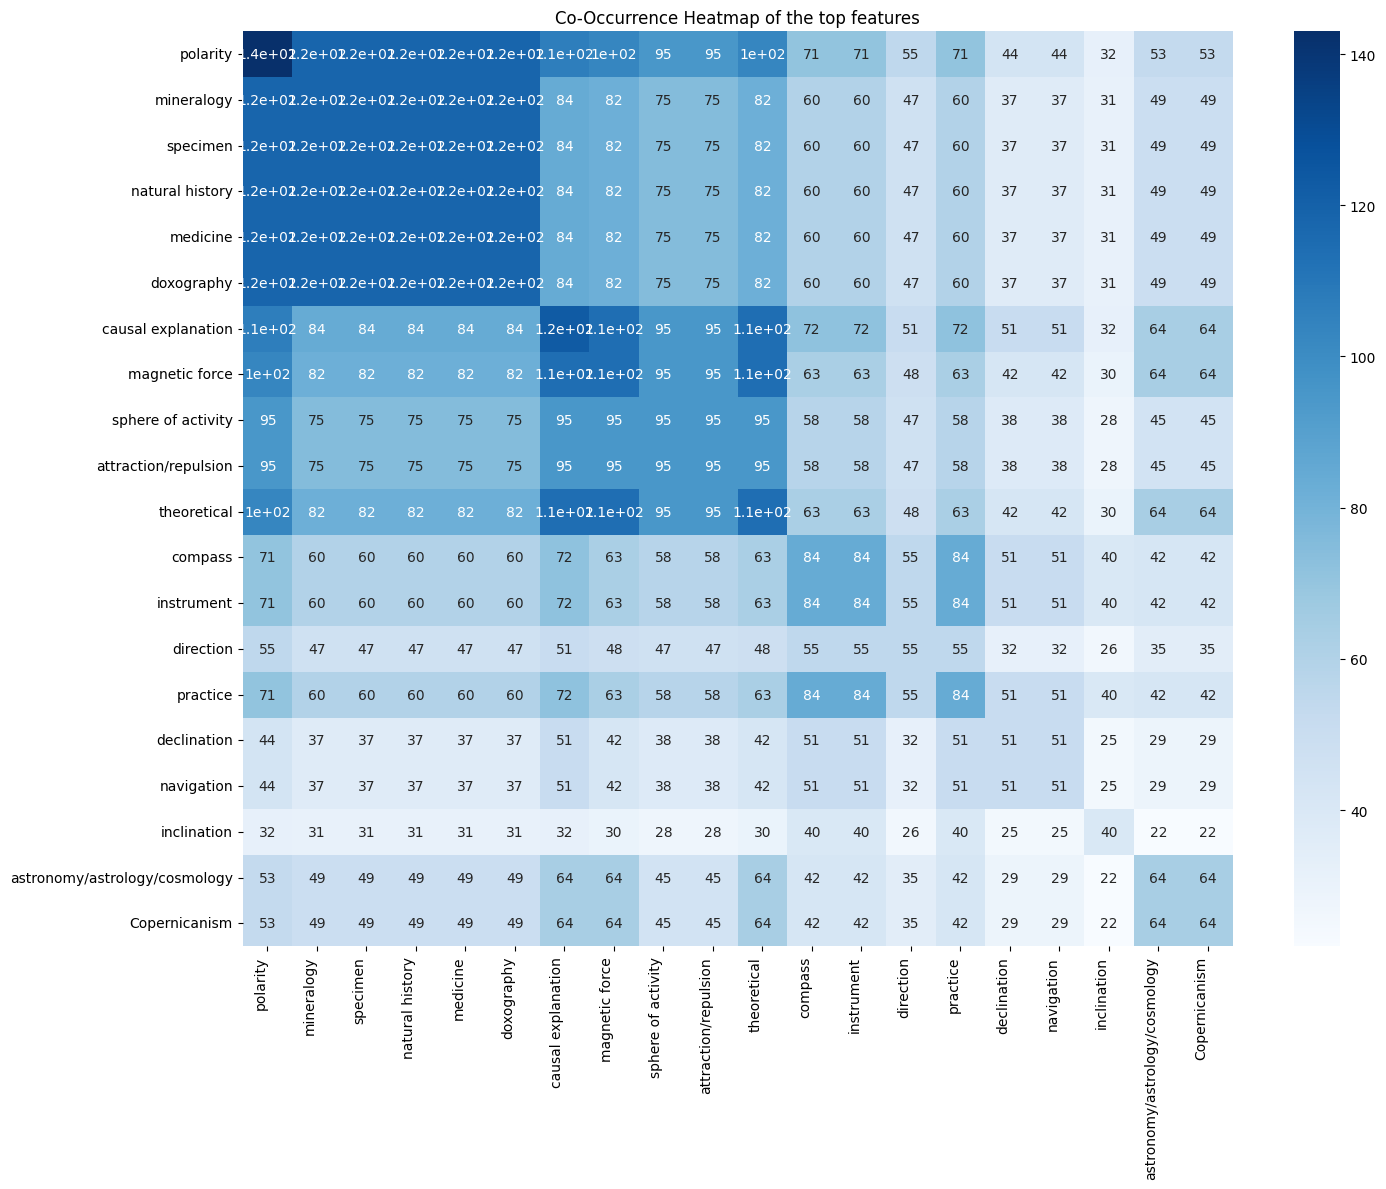

In [29]:
# Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.title("Co-Occurrence Heatmap of the top features")
plt.tight_layout()
plt.show()

In [30]:
co_occurrence_matrix.head(10)

,polarity,mineralogy,specimen,natural history,medicine,doxography,causal explanation,magnetic force,sphere of activity,attraction/repulsion,theoretical,compass,instrument,direction,practice,declination,navigation,inclination,astronomy/astrology/cosmology,Copernicanism
polarity,143,118,118,118,118,118,107,103,95,95,103,71,71,55,71,44,44,32,53,53
mineralogy,118,118,118,118,118,118,84,82,75,75,82,60,60,47,60,37,37,31,49,49
specimen,118,118,118,118,118,118,84,82,75,75,82,60,60,47,60,37,37,31,49,49
natural history,118,118,118,118,118,118,84,82,75,75,82,60,60,47,60,37,37,31,49,49
medicine,118,118,118,118,118,118,84,82,75,75,82,60,60,47,60,37,37,31,49,49
doxography,118,118,118,118,118,118,84,82,75,75,82,60,60,47,60,37,37,31,49,49
causal explanation,107,84,84,84,84,84,123,114,95,95,114,72,72,51,72,51,51,32,64,64
magnetic force,103,82,82,82,82,82,114,114,95,95,114,63,63,48,63,42,42,30,64,64
sphere of activity,95,75,75,75,75,75,95,95,95,95,95,58,58,47,58,38,38,28,45,45
attraction/repulsion,95,75,75,75,75,75,95,95,95,95,95,58,58,47,58,38,38,28,45,45


## PMI

If a combination \(x, y\) never occurs together, \(P(x, y) = 0\). Theoretically, this leads to the PMI becoming infinitely negative because \(log(0)\) tends to minus infinity.

### PMI Heatmap of the top features

C:\Users\c.sander\AppData\Local\Temp\ipykernel_9084\3717122544.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  reduced_pmi_matrix = pmi_matrix.loc[relevant_themes, relevant_themes]


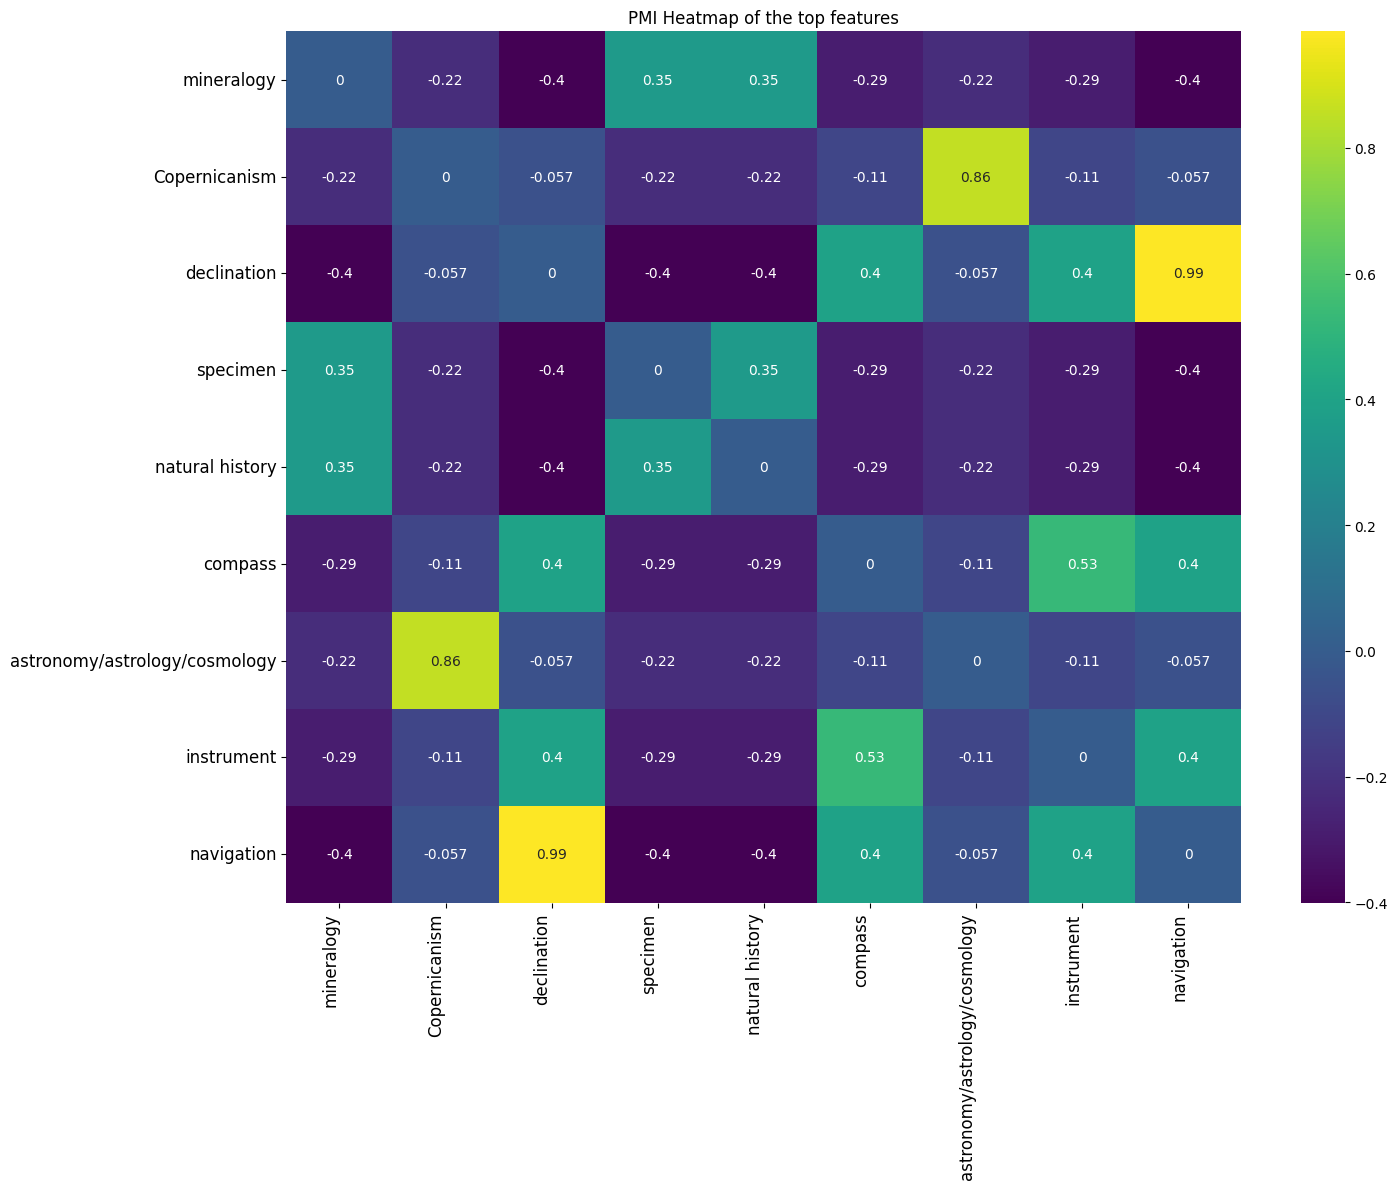

In [31]:
# Calculation of the total number of co-occurrences
total_co_occurrences = co_occurrence_matrix.sum().sum()

# Calculate individual probabilities of each topic
probabilities = {topic: co_occurrence_matrix[topic].sum() / total_co_occurrences for topic in top_topics}

# PMI matrix
pmi_matrix = pd.DataFrame(index=top_topics, columns=top_topics)

# Calculate PMI for each pair
for topic1 in top_topics:
    for topic2 in top_topics:
        if topic1 != topic2:  # Ignore self-references
            p_x_and_y = co_occurrence_matrix.at[topic1, topic2] / total_co_occurrences
            if p_x_and_y > 0:
                p_x = probabilities[topic1]
                p_y = probabilities[topic2]
                pmi = np.log2(p_x_and_y / (p_x * p_y))
                pmi_matrix.at[topic1, topic2] = pmi
            else:
                pmi_matrix.at[topic1, topic2] = 0


pmi_matrix = pmi_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)

# Converting the PMI matrix into a long format table
pmi_long = pmi_matrix.stack().reset_index()
pmi_long.columns = ['topic1', 'topic2', 'PMI']

# Selection of the top and bottom PMI values (set to 5)
top_5_pmi = pmi_long.nlargest(5, 'PMI')
bottom_5_pmi = pmi_long.nsmallest(5, 'PMI')
significant_pmi = pd.concat([top_5_pmi, bottom_5_pmi])

# Extract the relevant topics
relevant_themes = set(significant_pmi['topic1']).union(set(significant_pmi['topic2']))
reduced_pmi_matrix = pmi_matrix.loc[relevant_themes, relevant_themes]

plt.figure(figsize=(15, 12))
sns.heatmap(reduced_pmi_matrix, annot=True, cmap='viridis')
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title("PMI Heatmap of the top features", fontsize=12)
plt.tight_layout()
plt.show()


In [32]:
vector_df.columns

Index(['polarity', 'mineralogy', 'specimen', 'natural history', 'medicine',
       'doxography', 'causal explanation', 'magnetic force',
       'sphere of activity', 'attraction/repulsion', 'theoretical', 'compass',
       'instrument', 'direction', 'practice', 'declination', 'navigation',
       'inclination', 'astronomy/astrology/cosmology', 'Copernicanism'],
      dtype='object')

### PMI heatmap between annotation types and features

C:\Users\c.sander\AppData\Local\Temp\ipykernel_9084\2152267081.py:56: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  reduced_pmi_matrix = pmi_matrix.loc[relevant_annotation_types, relevant_themes]


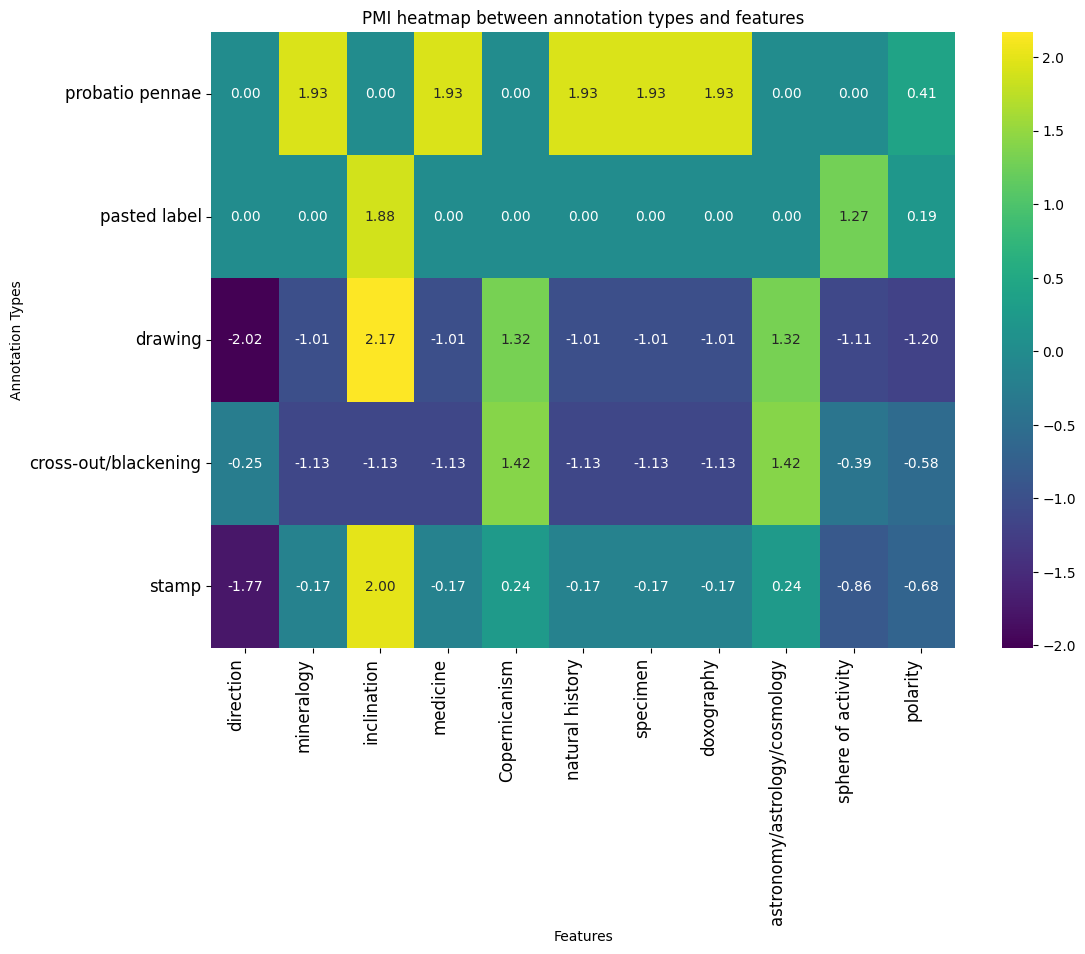

In [33]:
# List of all annotation types
annotation_types = annotations['annotation type'].unique()

# Initialize the co-occurrence matrix with zeros
co_occurrence_matrix = pd.DataFrame(0, index=annotation_types, columns=top_topics)

# Walk through all the highlights and update the co-occurrence matrix
for index, row in annotations.iterrows():
    if row['copy.Id'] in vector_df.index:  # check on ID
        annotation_type = row['annotation type']
        sec_ids_string = row['concat(substructures.Id)']
        if isinstance(sec_ids_string, str):
            sec_ids = sec_ids_string.split(',')
            for sec_id in sec_ids:
                matching_rows = sections[sections['Id'] == int(sec_id)]
                if not matching_rows.empty:
                    topics = matching_rows[topic_row].iloc[0]
                    if isinstance(topics, str):
                        cleaned_topics = [topic.strip() for topic in topics.split(',') if topic.strip() not in ignore_list]
                        for topic in cleaned_topics:
                            if topic in top_topics:
                                co_occurrence_matrix.at[annotation_type, topic] += 1


total_co_occurrences = co_occurrence_matrix.values.sum()

# Probabilities for each annotation type and topic
p_annotation = co_occurrence_matrix.sum(axis=1) / total_co_occurrences
p_topic = co_occurrence_matrix.sum(axis=0) / total_co_occurrences

# PMI matrix
pmi_matrix = pd.DataFrame(index=annotation_types, columns=top_topics)
pmi_matrix = pmi_matrix.astype(float).fillna(0)

# Calculate PMI for each pair of annotation type and topic
for annotation in annotation_types:
    for topic in top_topics:
        p_x_and_y = co_occurrence_matrix.at[annotation, topic] / total_co_occurrences
        if p_x_and_y > 0:  # Avoid logarithm of zero
            p_x = p_annotation[annotation]
            p_y = p_topic[topic]
            pmi = np.log2(p_x_and_y / (p_x * p_y))
            pmi_matrix.at[annotation, topic] = pmi
        else:
            pmi_matrix.at[annotation, topic] = 0

pmi_matrix = pmi_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
pmi_long = pmi_matrix.stack().reset_index()
pmi_long.columns = ['topic1', 'topic2', 'PMI']
top_5_pmi = pmi_long.nlargest(10, 'PMI')
bottom_5_pmi = pmi_long.nsmallest(10, 'PMI')
significant_pmi = pd.concat([top_5_pmi, bottom_5_pmi])
relevant_annotation_types = set(significant_pmi['topic1'])  # annotation types
relevant_themes = set(significant_pmi['topic2'])  # features

reduced_pmi_matrix = pmi_matrix.loc[relevant_annotation_types, relevant_themes]



plt.figure(figsize=(12, 8))
sns.heatmap(reduced_pmi_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("PMI heatmap between annotation types and features")
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel("Features")
plt.ylabel("Annotation Types")
plt.show()

### PMI heatmap between annotation types and positions

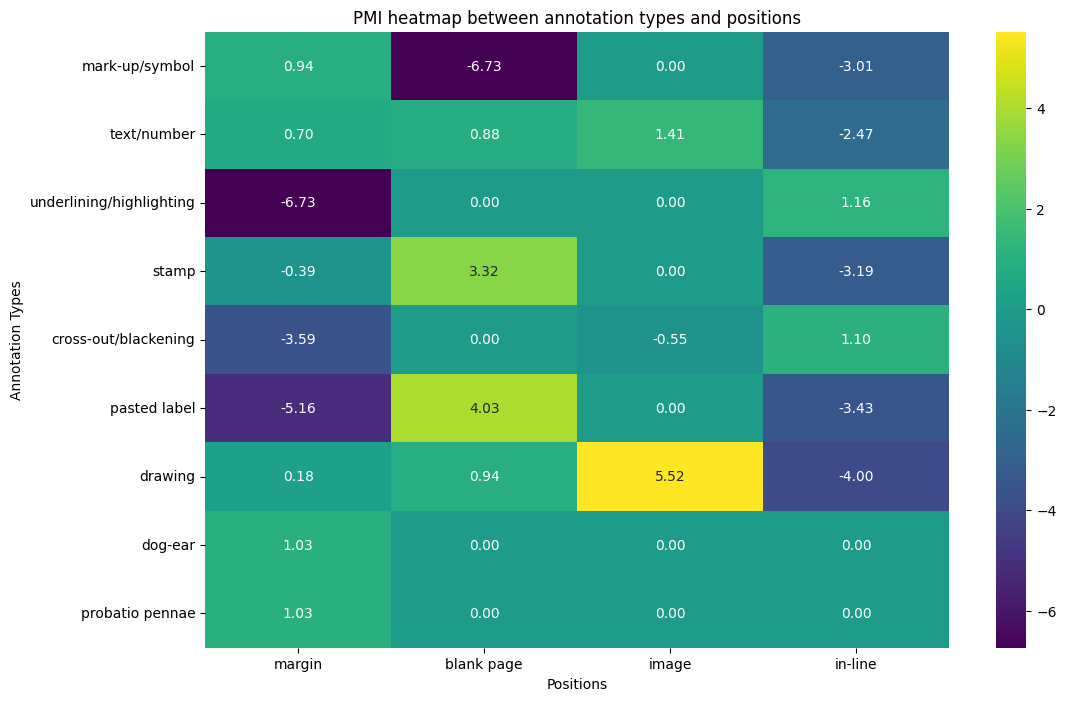

In [34]:
# List of all annotation types
annotation_types = annotations['annotation type'].unique()

# Extract positions
position_values = set()
annotations['position'].dropna().str.split(',').apply(lambda x: position_values.update([pos.strip() for pos in x]))

position_values = list(position_values)
co_occurrence_matrix = pd.DataFrame(0, index=annotation_types, columns=position_values)

# Like before...
for _, row in annotations.iterrows():
    if pd.notna(row['position']):
        positions = [pos.strip() for pos in row['position'].split(',')]
        annotation_type = row['annotation type']
        for pos in positions:
            co_occurrence_matrix.at[annotation_type, pos] += 1

total_co_occurrences = co_occurrence_matrix.values.sum()
p_annotation = co_occurrence_matrix.sum(axis=1) / total_co_occurrences
p_position = co_occurrence_matrix.sum(axis=0) / total_co_occurrences
pmi_matrix = pd.DataFrame(index=annotation_types, columns=position_values)
pmi_matrix = pmi_matrix.astype(float).fillna(0)

for annotation in annotation_types:
    for pos in position_values:
        p_x_and_y = co_occurrence_matrix.at[annotation, pos] / total_co_occurrences
        if p_x_and_y > 0:
            p_x = p_annotation[annotation]
            p_y = p_position[pos]
            pmi = np.log2(p_x_and_y / (p_x * p_y))
            pmi_matrix.at[annotation, pos] = pmi
        else:
            pmi_matrix.at[annotation, pos] = 0

plt.figure(figsize=(12, 8))
sns.heatmap(pmi_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("PMI heatmap between annotation types and positions")
plt.xlabel("Positions")
plt.ylabel("Annotation Types")
plt.show()



# Cluster

c:\Users\c.sander\AppData\Local\miniconda3\envs\stable\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\c.sander\AppData\Local\miniconda3\envs\stable\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Cluster kmeans 0: 45 items
Cluster kmeans 1: 20 items
Cluster kmeans 2: 16 items
Cluster kmeans 3: 60 items
Cluster kmeans 4: 18 items
Cluster kmeans 5: 6 items


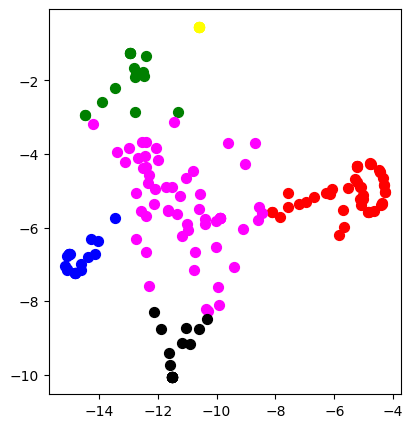

In [35]:
from sklearn.preprocessing import StandardScaler
ndata_arr = vector_df.drop(columns=['Id', 'index','level_0'], errors='ignore') # ohne Filter
X = ndata_arr 

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

n_cls = 6
kmeans = KMeans(n_clusters=n_cls, random_state=42, n_init=10).fit(X)
label = kmeans.labels_
color = ['red', 'blue', 'green', 'magenta', 'black', 'yellow', 'cyan']

# Create the agglomerative clustering model with the desired metric (e.g. 'manhattan')
# agg_cluster = AgglomerativeClustering(n_clusters=n_cls, affinity='manhattan', linkage='average')
# agg_labels = agg_cluster.fit_predict(ndata_arr)

# 2D
# pca = PCA(n_components=10)
# ndata_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
ndata_2d = tsne.fit_transform(X) # or ndata_pca

# Count the number of items in each cluster
cluster_counts = np.bincount(label)

for i, count in enumerate(cluster_counts):
    print(f"Cluster kmeans {i}: {count} items")

# Counter to count the number of items in each cluster
# cluster_counts = Counter(agg_labels)

# for cluster, count in cluster_counts.items():
#     print(f"Cluster AGG {cluster}: {count} items")

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(n_cls):
    plt.scatter(ndata_2d[label == i][:, 0], ndata_2d[label == i][:, 1], s=50, c=color[i], label=f"Cluster {i}")


In [37]:
ids = vector_df.index

# Create a DataFrame for the output
cluster_df = pd.DataFrame({
    'Id': ids,
    'Cluster': label
})
cluster_df.to_csv('output/cluster_assignments.csv', index=False)


In [38]:
vector_df.head(3)

,polarity,mineralogy,specimen,natural history,medicine,doxography,causal explanation,magnetic force,sphere of activity,attraction/repulsion,theoretical,compass,instrument,direction,practice,declination,navigation,inclination,astronomy/astrology/cosmology,Copernicanism
Id,,,,,,,,,,,,,,,,,,,,
1013,0.100000,0.066667,0.066667,0.066667,0.066667,0.066667,0.10000,0.033333,0.033333,0.033333,0.033333,0.066667,0.066667,0.0,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000
1020,0.151737,0.138940,0.138940,0.138940,0.138940,0.138940,0.02925,0.029250,0.012797,0.012797,0.029250,0.001828,0.001828,0.0,0.001828,0.000000,0.000000,0.001828,0.016453,0.016453
1021,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### t-SNE Visualization of Clusters with Scaled Point Sizes and Annotations
This generates a 2D scatter plot to visualize clusters identified by t-SNE. Each point represents a data point, and its size is scaled according to the sum of its row values (excluding the 'Id' column). The plot also includes annotations indicating the cluster, row sum, and identifier for each point.

In [39]:
pid = vector_df.index
copies.set_index('Id', inplace=True)
file_ids = copies.loc[pid, 'File ID']
edition_code = copies.loc[pid, 'Edition']
owner = copies.loc[pid, 'Library']

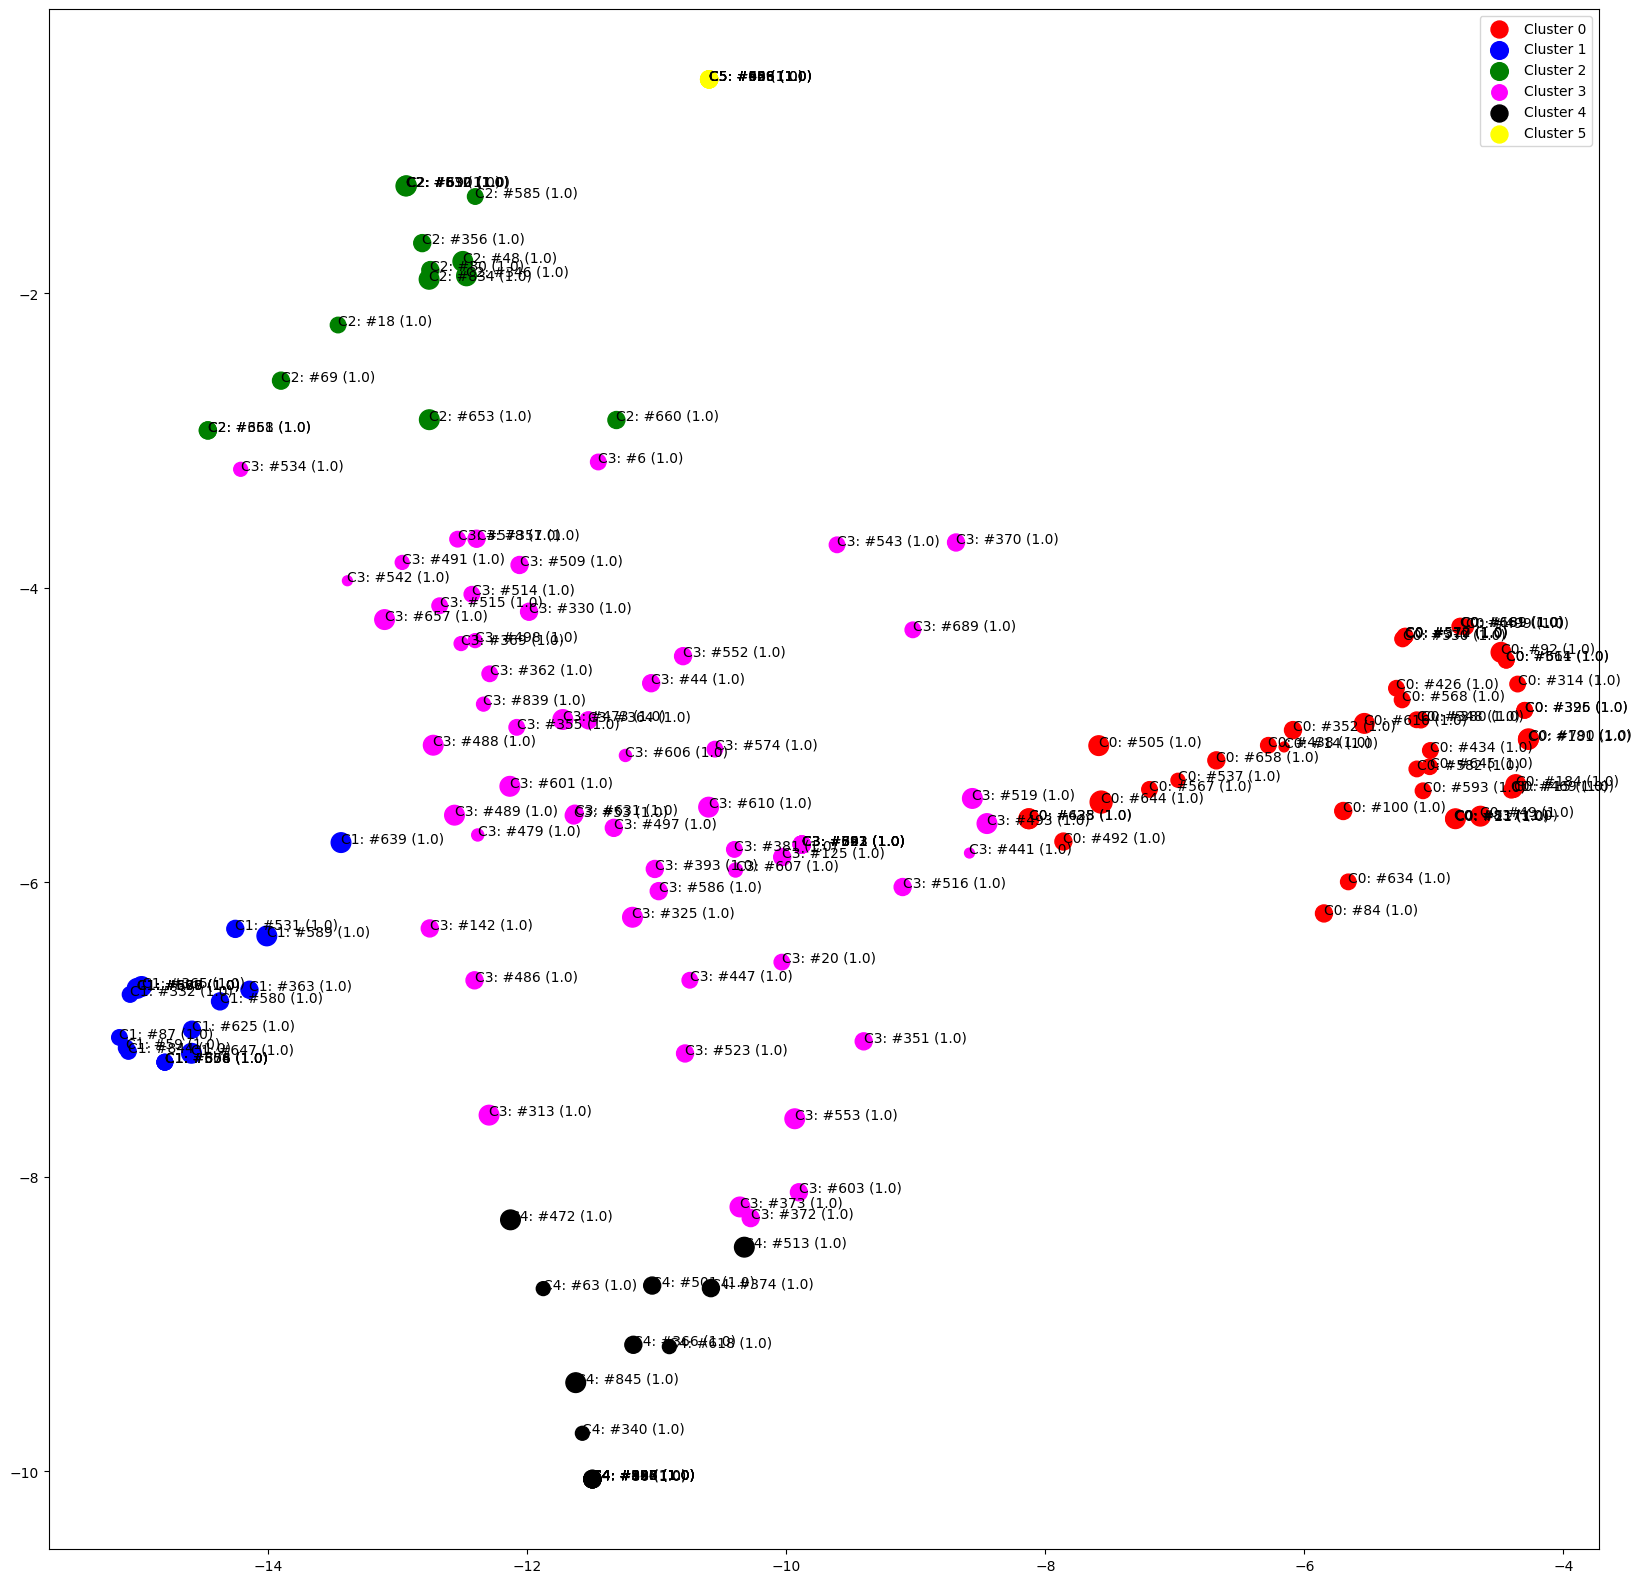

In [41]:
plt.figure(figsize=(20,20))

# Get the row sum from data for each point (ignore the 'Id' column)
row_sums = vector_df.sum(axis=1).values

# Get the min and max values of row_sums
min_sum = min(row_sums)
max_sum = max(row_sums)

# Scale the sums
scaled_sizes = 50 + (row_sums - min_sum) * (200 - 1) / (max_sum - min_sum)

# Plot
for i in range(n_cls):
    sub_index = np.where(label == i)
    sub_arr = ndata_2d[sub_index]
    sub_sizes = scaled_sizes[sub_index]
    plt.scatter(sub_arr[:,0], sub_arr[:,1], c=color[i], s=sub_sizes, label=f"Cluster {i}")

# Annotations with pid, the corresponding row total and the cluster
for i, (txt, row_sum) in enumerate(zip(file_ids, row_sums)):
    cluster_id = label[i]
    annotation_label = f"C{cluster_id}: #{txt} ({round(row_sum, 1)})"
    plt.annotate(annotation_label, (ndata_2d[i,0], ndata_2d[i,1]))

plt.legend()
plt.savefig("output/plots/tsne_topics_clustered_labeled.png", dpi=300)
plt.show()

In [42]:
# Reset the original index of vector_df to access 'Id'
# vector_df.reset_index(inplace=True)

# Merging the DataFrame df with the t-SNE data based on "File ID" / pid
merged_df = pd.merge(vector_df, copies, left_on='Id', right_on='Id')
merged_df.to_csv('output/tsne_merged.csv')

In [44]:
from bokeh.models import ColumnDataSource, HoverTool, ColorBar
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, TextInput, CustomJS, HoverTool
from bokeh.models import CDSView, GroupFilter
from bokeh.palettes import Category10

color_list = Category10[10]
colors = [color_list[l] for l in label]
unique_labels = list(set(label))

source = ColumnDataSource(data=dict(
    x=ndata_2d[:, 0],
    y=ndata_2d[:, 1],
    label=label,
    sizes=scaled_sizes/8,
    pid=file_ids.values,
    row_sum=row_sums,
    library=owner.values,
    edition=edition_code.values,
    color=colors,
    original_color=colors.copy()
))

# Plot
p = figure(width=1000, height=1000, title="t-SNE Clustered Data")
p.scatter(x='x', y='y', source=source, size='sizes', color='color', legend_field='label', fill_alpha=0.6)


p.legend.click_policy = "hide"

hover = HoverTool()
hover.tooltips = [
    ("PID", "@pid"),
    ("Cluster", "@label"),
    ("Sum", "@row_sum"),
    ("Library", "@library"),
    ("Edition", "@edition")
]
p.add_tools(hover)
input_widget = TextInput(title="Search by Library:", value="")

callback = CustomJS(args=dict(source=source), code="""
    const data = source.data;
    const value = cb_obj.value.toLowerCase();
    const library = data['library'];
    const color = data['color'];
    const original_color = data['original_color'];

    for (let i = 0; i < library.length; i++) {
        if (value === "" || library[i].toLowerCase().includes(value)) {
            color[i] = original_color[i];  // Use the original color
        } else {
            color[i] = "grey";  // Color for non-matching
        }
    }
    source.change.emit();
""")

input_widget.js_on_change("value", callback)
layout = column(input_widget, p)
output_file("output/interactive/tSNE_Bokeh_Search_topics.html")
show(layout)


# Features

In [45]:
data2 = vector_df.drop(columns=['index','level_0'], errors='ignore').copy()

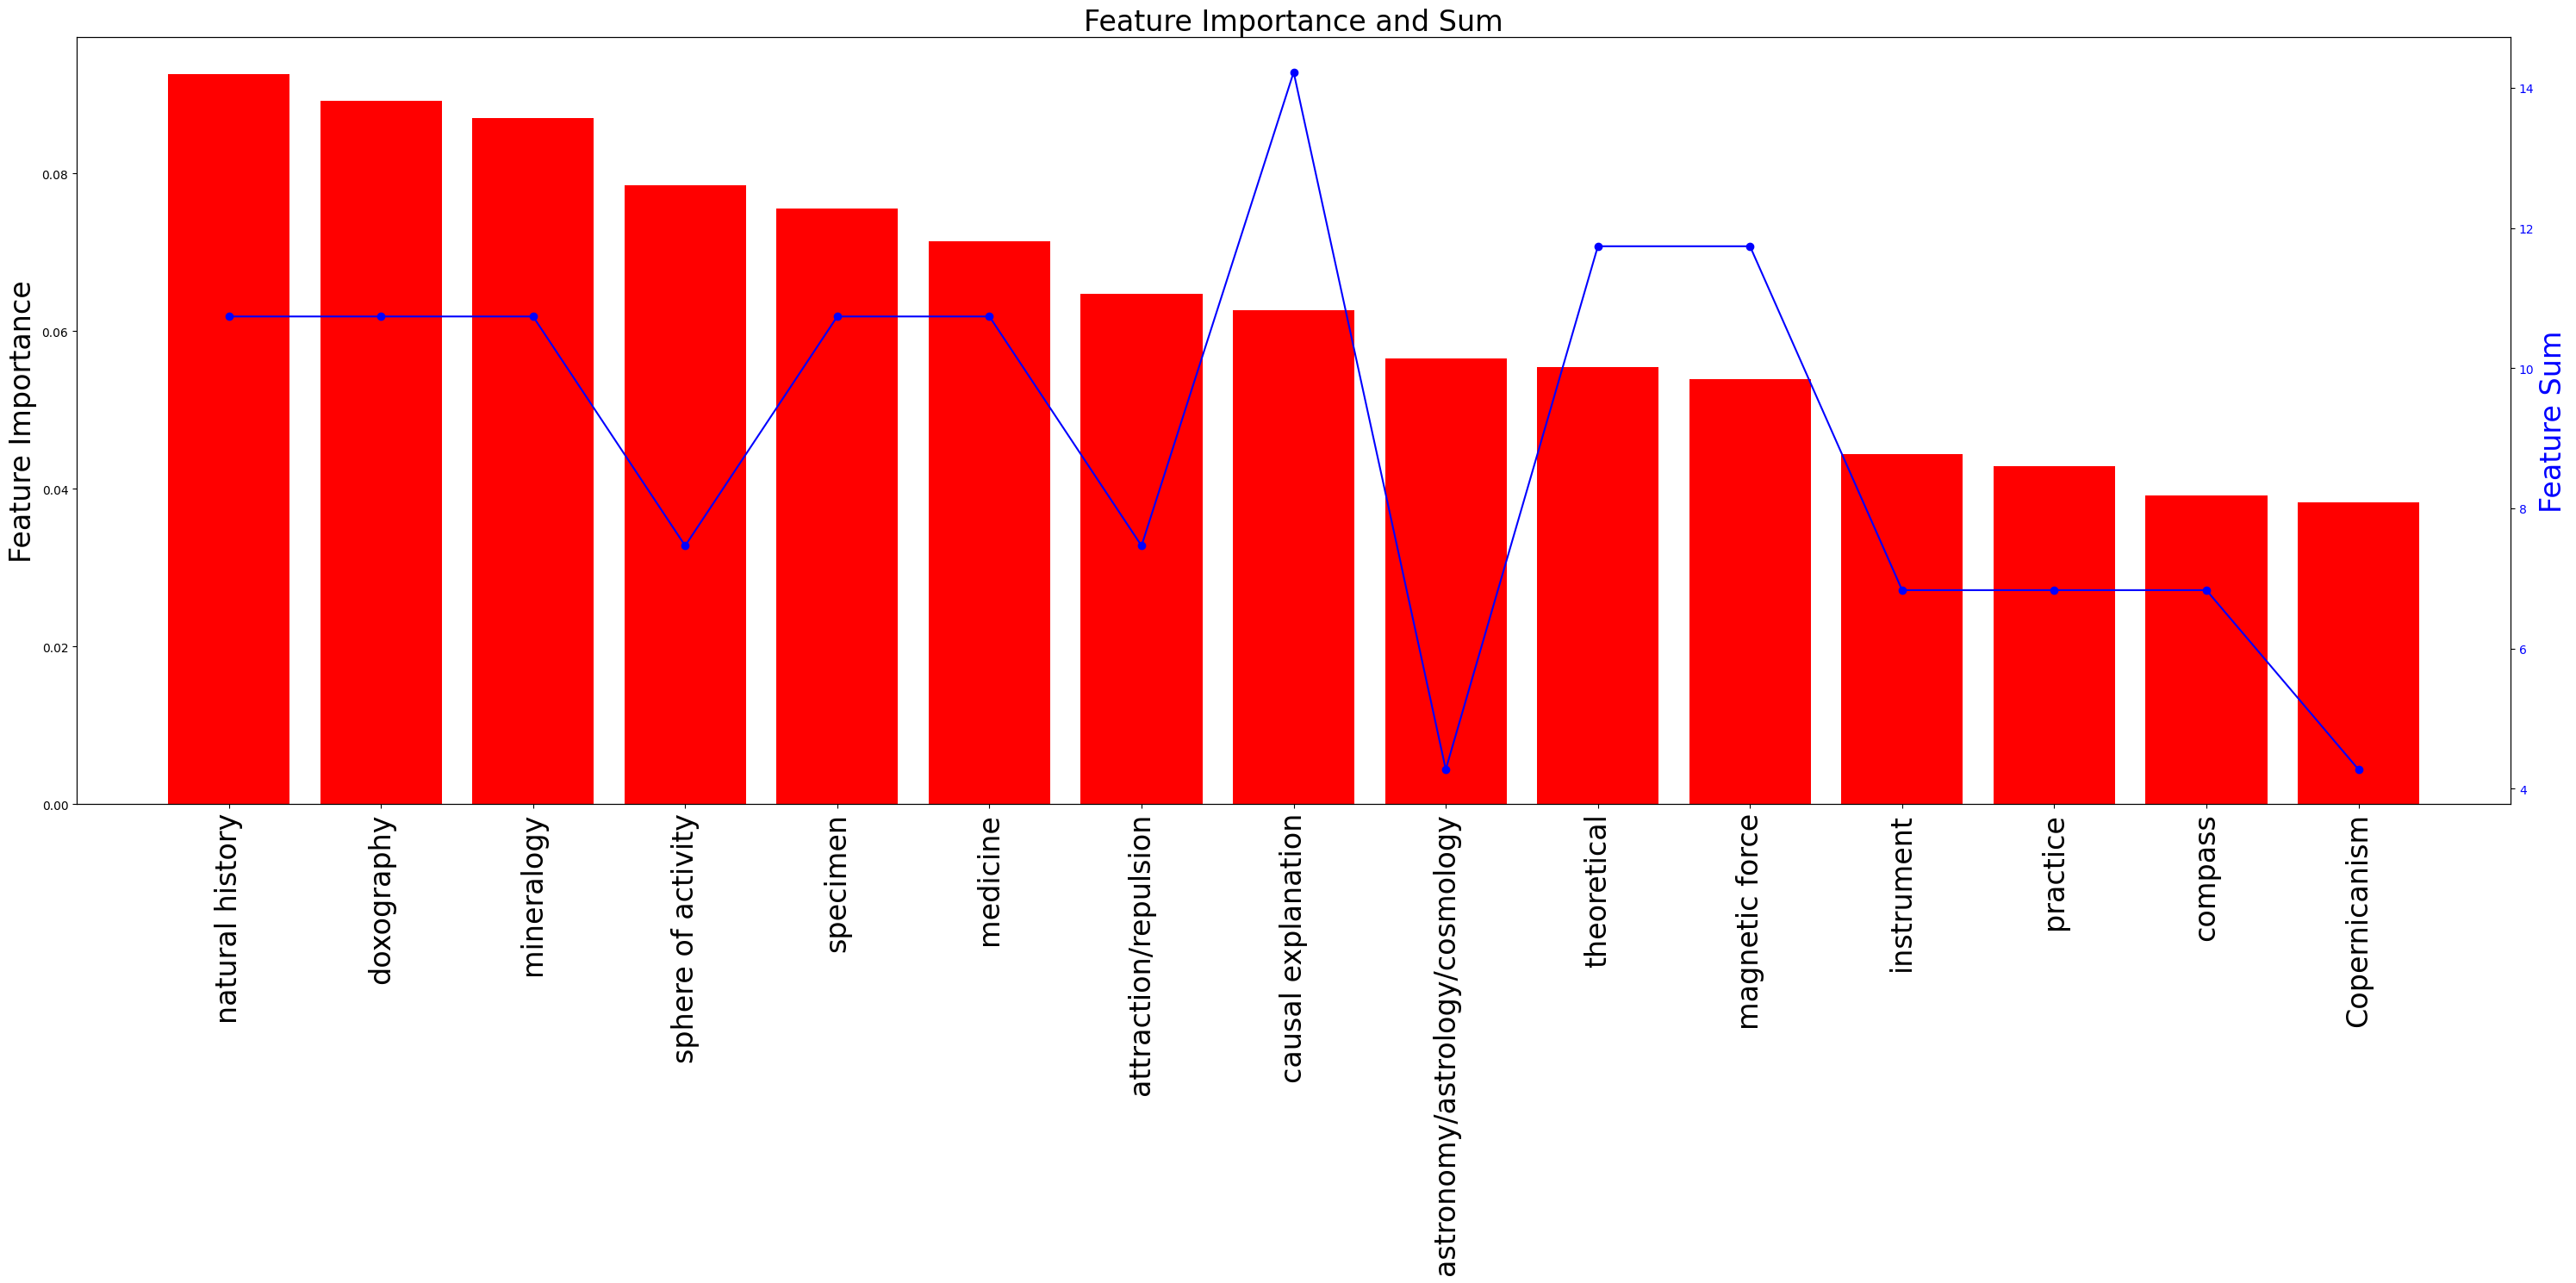

In [46]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Number of features to be shown
num_features_to_show = min(15, X.shape[1]) 
# Drop the first column in ndata
X = data2.iloc[:, 1:]
y = kmeans.labels_

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Feature Importance
importances = clf.feature_importances_

# Sort column names (without the first column) and their meaning in descending order
features = X.columns
indices = np.argsort(importances)[::-1]

# Make sure that the column order of 'data' and 'ndata' is identical, without the first column
data2 = data2[features]

# Sum of the feature values in 'data'
feature_sums = data2.sum(axis=0)

# Plot
fig, ax1 = plt.subplots(figsize=(30,15))
# Second axis for Feature-Importance
ax1.set_title("Feature Importance and Sum", fontsize=24)
ax1.bar(range(num_features_to_show), importances[indices][:num_features_to_show], color="r", align="center")
ax1.set_xticks(range(num_features_to_show))
ax1.set_xticklabels([features[i] for i in indices[:num_features_to_show]], rotation=90, fontsize=24)
ax1.set_xlim([-1, num_features_to_show])
ax1.set_ylabel("Feature Importance", fontsize=24)
plt.xticks(rotation=90, fontsize=24)
# Second axis for the sum of the feature values
ax2 = ax1.twinx()
ax2.plot(range(num_features_to_show), feature_sums[indices][:num_features_to_show], color="b", marker="o", linestyle="-")
ax2.set_ylabel("Feature Sum", color="b", fontsize=24)
ax2.tick_params(axis='y', labelcolor="b")
plt.savefig(f"output/plots/topics_feature_importance_all.png", dpi=300)

plt.tight_layout()
plt.show()


In [47]:
def identify_top_overrepresented_features(data, labels, top_n=10):
    # Calculate the global mean values of the features
    global_means = data.mean()
    
    # Determine the unique clusters
    clusters = np.unique(labels)
    
    # Create a dictionary to store the results for each cluster
    overrepresented_features_per_cluster = {}

    # Analysis for each cluster
    for cluster in clusters:
        # Extract the data of the current cluster
        cluster_data = data[labels == cluster]
        
        # Calculate the mean value of each feature in the cluster
        cluster_means = cluster_data.mean()
        
        # Calculate the ratio of the cluster mean values to the global mean values
        ratios = cluster_means / global_means
        
        # Identify features whose ratio is above a certain threshold value
        threshold = 1
        overrepresented_features = ratios[ratios > threshold]
        
        # Sort the features according to their overrepresentation ratio in descending order
        sorted_features = overrepresented_features.sort_values(ascending=False)
        
        # Save the top N overrepresented features for this cluster
        top_features = sorted_features.head(top_n)
        overrepresented_features_per_cluster[cluster] = [(feature, ratio) for feature, ratio in top_features.items()]
    
    return overrepresented_features_per_cluster

overrepresented_features = identify_top_overrepresented_features(data2, y)

# Print results
for cluster, features in overrepresented_features.items():
    print(f"Cluster {cluster}:")
    for feature, ratio in features:
        print(f"  {feature}: {ratio:.2f}")


Cluster 0:
  mineralogy: 2.37
  specimen: 2.37
  natural history: 2.37
  medicine: 2.37
  doxography: 2.37
Cluster 1:
  sphere of activity: 3.48
  attraction/repulsion: 3.48
  magnetic force: 2.23
  theoretical: 2.23
  causal explanation: 1.84
Cluster 2:
  declination: 6.51
  navigation: 6.51
  compass: 3.78
  instrument: 3.78
  practice: 3.78
  direction: 3.45
  causal explanation: 1.29
  inclination: 1.07
Cluster 3:
  direction: 1.52
  sphere of activity: 1.36
  attraction/repulsion: 1.36
  magnetic force: 1.14
  theoretical: 1.14
  causal explanation: 1.09
Cluster 4:
  astronomy/astrology/cosmology: 6.35
  Copernicanism: 6.35
  magnetic force: 2.38
  theoretical: 2.38
  causal explanation: 2.05
Cluster 5:
  inclination: 18.48
  compass: 6.04
  instrument: 6.04
  practice: 6.04


In [48]:
myrange=15

Analysis of feature importance for clusters using a RandomForestClassifier. The key tasks are creating one-vs-all labels for each cluster, training a classifier, and plotting the most important features along with their summed values for each cluster.

In [49]:
# Stellen Sie sicher, dass features die Namen der 40 häufigsten Themen enthält
features = vector_df.columns[1:]  # Überspringe die 'Id' Spalte
print(f"Features: {features}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming X, y, features, and data2 are already defined
for cluster_id in set(y):
    # Create one-vs-all label
    y_one_vs_all = np.array([1 if label == cluster_id else 0 for label in y])

    # Train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y_one_vs_all)

    # Extract feature importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort indices by importance, descending

    print(f"Cluster {cluster_id} - Indices: {indices}")

    # Calculate the sum per feature for all items in the current cluster
    cluster_data_absolute = data2[y == cluster_id]
    feature_sums_absolute = cluster_data_absolute.sum(axis=0)

    # Determine the number of features to consider (maximum 30)
    num_features = min(len(indices), 30)

    # Ensure indices are within the valid range of 'features'
    valid_indices = [i for i in indices[:num_features] if i < len(features)]

    print(f"Cluster {cluster_id} - Valid Indices: {valid_indices}")

    # Skip this cluster if there are no valid indices
    if not valid_indices:
        print(f"Cluster {cluster_id} has no valid features.")
        continue

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.set_title(f"Feature Importance and Sum for Cluster {cluster_id}")
    ax1.bar(range(len(valid_indices)), importances[valid_indices], color="r", align="center")
    ax1.set_xticks(range(len(valid_indices)))
    ax1.set_xticklabels([features[i] for i in valid_indices], rotation=90)
    ax1.set_xlim([-1, len(valid_indices)])
    ax1.set_ylabel("Feature Importance")
    ax1.set_ylim([0, max(importances[valid_indices]) * 1.1])

    # Second axis for the sum of feature values
    ax2 = ax1.twinx()
    ax2.plot(range(len(valid_indices)), feature_sums_absolute[valid_indices], color="b", marker="o", linestyle="-")
    ax2.set_ylabel("Feature Sum in Cluster", color="b")
    ax2.tick_params(axis='y', labelcolor="b")
    ax2.set_ylim([0, max(feature_sums_absolute[valid_indices]) * 1.1])

    plt.tight_layout()
    plt.savefig(f"output/plots/topics_feature_importance_and_sum_cluster_{cluster_id}.png", dpi=300)
    plt.close()

    # Print the feature importance and feature sums for the current cluster
    print(f"Cluster {cluster_id} - Top {len(valid_indices)} Features Importance and Sums:")
    for i in valid_indices:
        print(f"    {features[i]}: Importance = {importances[i]:.4f}, Sum = {feature_sums_absolute[i]:.2f}")


Features: Index(['mineralogy', 'specimen', 'natural history', 'medicine', 'doxography',
       'causal explanation', 'magnetic force', 'sphere of activity',
       'attraction/repulsion', 'theoretical', 'compass', 'instrument',
       'direction', 'practice', 'declination', 'navigation', 'inclination',
       'astronomy/astrology/cosmology', 'Copernicanism'],
      dtype='object')
Cluster 0 - Indices: [ 2  4  0  1  3  5  9  6 11 10 13  8 14  7 17 12 15 16 18]
Cluster 0 - Valid Indices: [2, 4, 0, 1, 3, 5, 9, 6, 11, 10, 13, 8, 14, 7, 17, 12, 15, 16, 18]
Cluster 0 - Top 19 Features Importance and Sums:
    natural history: Importance = 0.2050, Sum = 6.93
    doxography: Importance = 0.1813, Sum = 6.93
    mineralogy: Importance = 0.1757, Sum = 6.93
    specimen: Importance = 0.1493, Sum = 6.93
    medicine: Importance = 0.1156, Sum = 6.93
    causal explanation: Importance = 0.0653, Sum = 0.44
    theoretical: Importance = 0.0303, Sum = 0.44
    magnetic force: Importance = 0.0292, Sum = 

Identify the top 10 important features for each cluster using a RandomForestClassifier and visualizes them using boxplots. The process involves creating a one-vs-all label for each cluster, training the classifier, and plotting the distribution of the top features for the cluster.

In [50]:
# Obtain the unique cluster labels
unique_labels = np.unique(kmeans.labels_)

# For each cluster
for label in unique_labels:

    # Create one-vs-all label: 1 for the current cluster, 0 for all others
    y_one_vs_all = [1 if l == label else 0 for l in kmeans.labels_]

    # Train the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data2, y_one_vs_all)

    # Extract feature importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort indices by importance in descending order

    # Select the 10 most important features
    top_features = [data2.columns[i] for i in indices[:10]]
    
    # Segment data for the current cluster
    cluster_data = data2[kmeans.labels_ == label]
    
    # Create a boxplot for the current cluster's top features
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=cluster_data[top_features])
    
    plt.title(f"Top 10 Important Features for Cluster {label}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Save the plot as a PNG file
    plt.savefig(f"output/plots/cluster_{label}_top_important_features_box_plot.png", dpi=300)
    plt.close()
